# Generative Modeling approach for Mining Online Reviews 

# 1) Importing key modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk import FreqDist

In [3]:
# For processing
import pandas as pd
import numpy as np
import re
import spacy
# For LDA
import gensim
from gensim import corpora

In [22]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2) Loading data

In [5]:
df = pd.read_json('Automotive_5.json', lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


the data contains the following columns:

- reviewerID – ID of the reviewer
- asin – ID of the product
- reviewerName – name of the reviewer
- helpful – helpfulness rating of the review, e.g. 2/3
- reviewText – text of the review
- overall – rating of the product
- summary – summary of the review
- unixReviewTime – time of the review (unix time)
- reviewTime – time of the review (raw)

For the scope of our analysis and this article, we will be using only the reviews column, i.e., **reviewText.**

# 3)-Data Preprocessing and cleaning

### 3.1)- Checking most fequent words

In [6]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

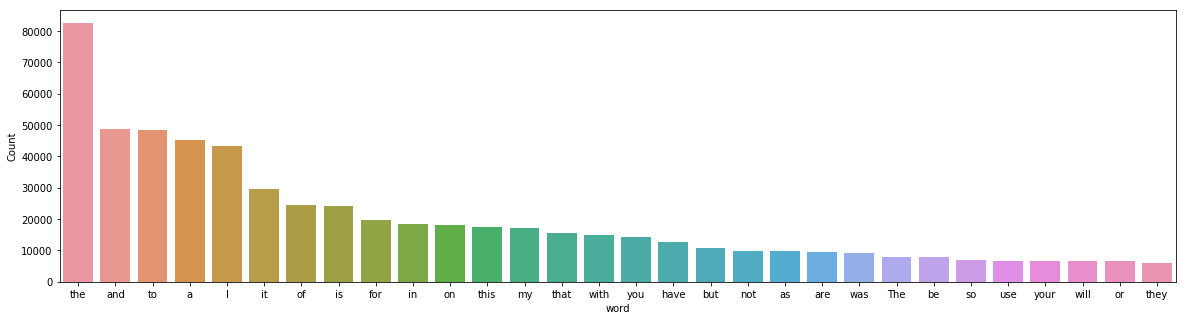

In [7]:
freq_words(df['reviewText'])

We can see that there are couple of unwanted words like "the, and, to, of" etc. They won't contribute to our analysis. so, we better remove em.

### 3.2)Remove unwanted characters, numbers and symbols

In [8]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [10]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

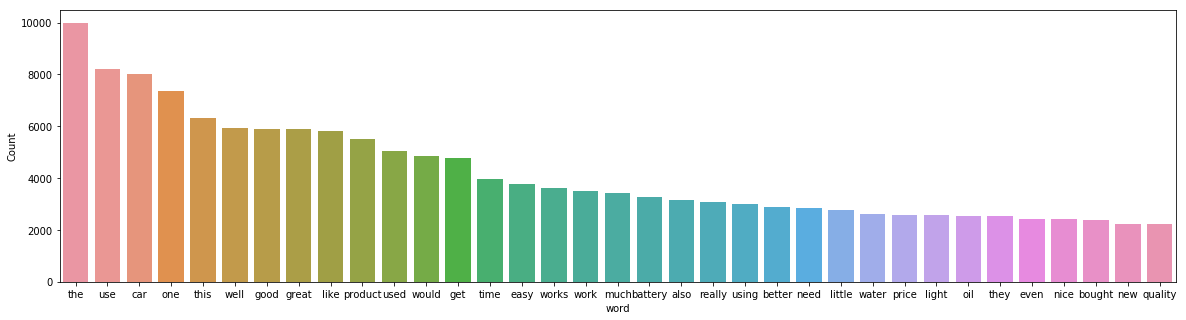

In [11]:
freq_words(reviews, 35)

### 3.3)-Lemmatization and tokenization

In [12]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [13]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [14]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [15]:
# check lemmatized review
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'snap', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


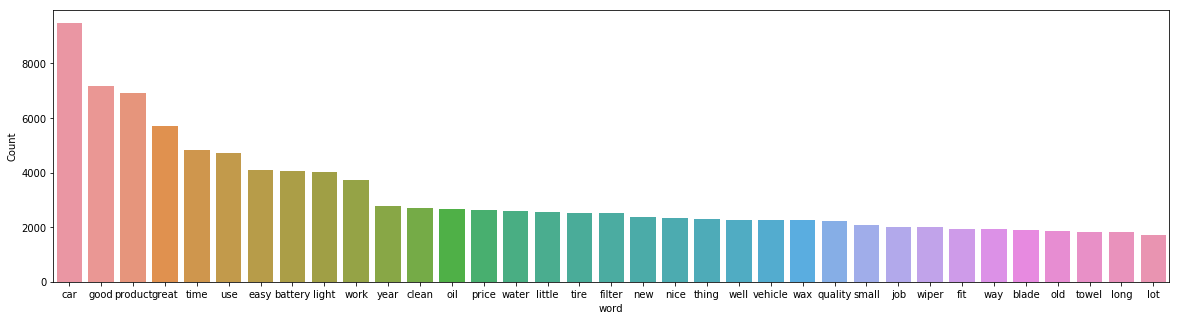

In [16]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

Finally words are making some sense

# 4)-Building an LDA model

In [17]:
dictionary = corpora.Dictionary(reviews_2)

In [18]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [19]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [20]:
lda_model.print_topics()

[(0,
  '0.026*"oil" + 0.020*"car" + 0.019*"filter" + 0.016*"engine" + 0.012*"code" + 0.011*"tank" + 0.011*"app" + 0.010*"change" + 0.010*"vehicle" + 0.009*"inverter"'),
 (1,
  '0.028*"tire" + 0.019*"hose" + 0.013*"pressure" + 0.011*"use" + 0.011*"gauge" + 0.010*"good" + 0.009*"water" + 0.009*"air" + 0.008*"bag" + 0.008*"time"'),
 (2,
  '0.056*"light" + 0.039*"battery" + 0.021*"car" + 0.020*"bulb" + 0.019*"power" + 0.015*"device" + 0.014*"bright" + 0.012*"unit" + 0.011*"charger" + 0.010*"phone"'),
 (3,
  '0.037*"product" + 0.036*"wax" + 0.021*"car" + 0.020*"paint" + 0.016*"kit" + 0.016*"pad" + 0.016*"black" + 0.013*"good" + 0.012*"surface" + 0.012*"finish"'),
 (4,
  '0.044*"car" + 0.026*"towel" + 0.023*"clean" + 0.022*"product" + 0.019*"water" + 0.017*"good" + 0.015*"leather" + 0.014*"great" + 0.013*"use" + 0.012*"wash"'),
 (5,
  '0.025*"wiper" + 0.024*"blade" + 0.022*"good" + 0.018*"price" + 0.013*"product" + 0.013*"great" + 0.011*"quality" + 0.011*"amazon" + 0.011*"windshield" + 0.011

The fourth topic Topic 3 has terms like ‘towel’, ‘clean’, ‘wax’, ‘water’, indicating that the topic is very much related to car-wash. Similarly, Topic 6 seems to be about the overall value of the product as it has terms like ‘price’, ‘quality’, and ‘worth’.

# 5)-Topics Visualization

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.049503  0.104053       1        1  18.699810
5     -0.023546 -0.011258       2        1  16.815130
1      0.170156 -0.101652       3        1  14.175553
2     -0.065299 -0.075263       4        1  14.071290
6      0.249973  0.020373       5        1  13.180696
0     -0.189296 -0.186664       6        1  12.546910
3     -0.092486  0.250409       7        1  10.510602, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
152   Default  4577.000000        light  4577.000000  30.0000  30.0000
38    Default  2982.000000      battery  2982.000000  29.0000  29.0000
525   Default  2084.000000          wax  2084.000000  28.0000  28.0000
529   Default  2617.000000        towel  2617.000000  27.0000  27.0000
335   Default  2189.000000         tire  2189.000000  26.0000  26.0000
3     Default  9402.000000          car  9402.000000  25.0000  25.0000
939   Default  2266.000000        wiper  2266.000000  24.0000  24.0000
966   Default  2256.000000        blade  2256.000000  23.0000  23.0000
97    Default  2359.000000        clean  2359.000000  22.0000  22.0000
170   Default  1784.000000          oil  1784.000000  21.0000  21.0000
316   Default  6414.000000      product  6414.000000  20.0000  20.0000
2596  Default  1578.000000         bulb  1578.000000  19.0000  19.0000
524   Default  2621.000000        water  2621.000000  18.0000  18.0000
728   Default  1468.000000         hose  1468.000000  17.0000  17.0000
978   Default  1315.000000       filter  1315.000000  16.0000  16.0000
63    Default  1536.000000        power  1536.000000  15.0000  15.0000
648   Default  1254.000000        paint  1254.000000  14.0000  14.0000
1326  Default  1530.000000      leather  1530.000000  13.0000  13.0000
48    Default  1815.000000          fit  1815.000000  12.0000  12.0000
120   Default  1120.000000       engine  1120.000000  11.0000  11.0000
762   Default  1150.000000       device  1150.000000  10.0000  10.0000
1283  Default  1114.000000       bright  1114.000000   9.0000   9.0000
18    Default  2266.000000        price  2266.000000   8.0000   8.0000
710   Default   922.000000          pad   922.000000   7.0000   7.0000
523   Default  1223.000000         wash  1223.000000   6.0000   6.0000
1567  Default  1426.000000          kit  1426.000000   5.0000   5.0000
530   Default  1183.000000        black  1183.000000   4.0000   4.0000
1115  Default   981.000000     pressure   981.000000   3.0000   3.0000
938   Default  1016.000000   windshield  1016.000000   2.0000   2.0000
726   Default   849.000000         code   849.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
447    Topic7   101.978638      coating   102.710365   2.2456  -6.3376
648    Topic7  1169.872314        paint  1254.058716   2.1833  -3.8977
1758   Topic7   164.536133     ultimate   168.426041   2.2294  -5.8593
1319   Topic7   559.254211      meguiar   614.057922   2.1593  -4.6358
564    Topic7   679.241272       finish   804.570618   2.0835  -4.4414
596    Topic7   508.535522        shine   597.656616   2.0913  -4.7309
530    Topic7   921.410645        black  1183.374146   2.0026  -4.1365
547    Topic7   616.402893       result   801.001892   1.9908  -4.5385
1567   Topic7   927.978638          kit  1426.694458   1.8227  -4.1294
718    Topic7   342.526917         step   463.383179   1.9506  -5.1260
199    Topic7   699.515259      surface  1228.156860   1.6899  -4.4120
593    Topic7   274.095001      scratch   359.509033   1.9815  -5.3489
944    Topic7   462.814880  application   751.063354   1.7686  -4.8251
316    Topic7  2122.152100      product  6414.453125   1.1467  -3.3022
1270   Topic7   278.178558   protection   400.803040   1.8876  -5.3341
539    Topic7   520.712097        clear  1083.743164   1.5198  

**We can improve things by using TF-IDF model added to bag of word and then use that model to LDA. This might provide better solutions and more relevant topics.For an initial basice introduction, this approach is fine and suitable though**